## Name: Aksa Elizabeth Sunny

### ASU ID: 1227737175

# TASK 1

# 1. Data Preprocessing


In [23]:
# For data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [24]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

In [25]:
# Extract Title from Name
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplifying titles
for dataset in [train_df, test_df]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Use KNN imputation for the Age feature
imputer = KNNImputer(n_neighbors=5)
train_df['Age'] = imputer.fit_transform(train_df[['Age']])
test_df['Age'] = imputer.transform(test_df[['Age']])

# Extract deck information from the Cabin feature
train_df['Deck'] = train_df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'M')
test_df['Deck'] = test_df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'M')

# One-hot encoding for categorical features
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked', 'Title', 'Deck'])
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked', 'Title', 'Deck'])

# For train and test dataframes to have the same columns after one-hot encoding
missing_columns = set(train_df.columns) - set(test_df.columns)
for col in missing_columns:
    test_df[col] = 0
test_df = test_df[train_df.columns]

# Drop columns that might not be necessary or have been transformed
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns + ["Survived"], axis=1)
print(type(train_df))

# Scale the features
scaler = StandardScaler()
Y_train = train_df["Survived"]

train_df = train_df.drop("Survived", axis=1)
X_train_scaled = scaler.fit_transform(train_df)
X_test_scaled = scaler.transform(test_df)

X_train = pd.DataFrame(X_train_scaled, columns=train_df.columns)
X_test = pd.DataFrame(X_test_scaled, columns=test_df.columns)

<class 'pandas.core.frame.DataFrame'>


# 2. Learn and fine tune the Decision tree

In [26]:
# Split the dataset into training and testing sets
X_train, X_value, y_train, y_value = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = dt_classifier.score(X_value, y_value)
print(f"Accuracy of the Decision Tree: {accuracy:.2f}")

# Fine-tune the Decision Tree with hyperparameter tuning
params = {
    'max_depth': [3, 5, 7,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring = "accuracy")
grid_search.fit(X_train, y_train)

dt_classifier_fine_tuned = grid_search.best_estimator_
fine_tuned_accuracy = dt_classifier_fine_tuned.score(X_value, y_value)
print(f"Accuracy after Hyperparameter Tuning: {fine_tuned_accuracy:.2f}")

Accuracy of the Decision Tree: 0.79
Accuracy after Hyperparameter Tuning: 0.82


## Decision Tree Plot

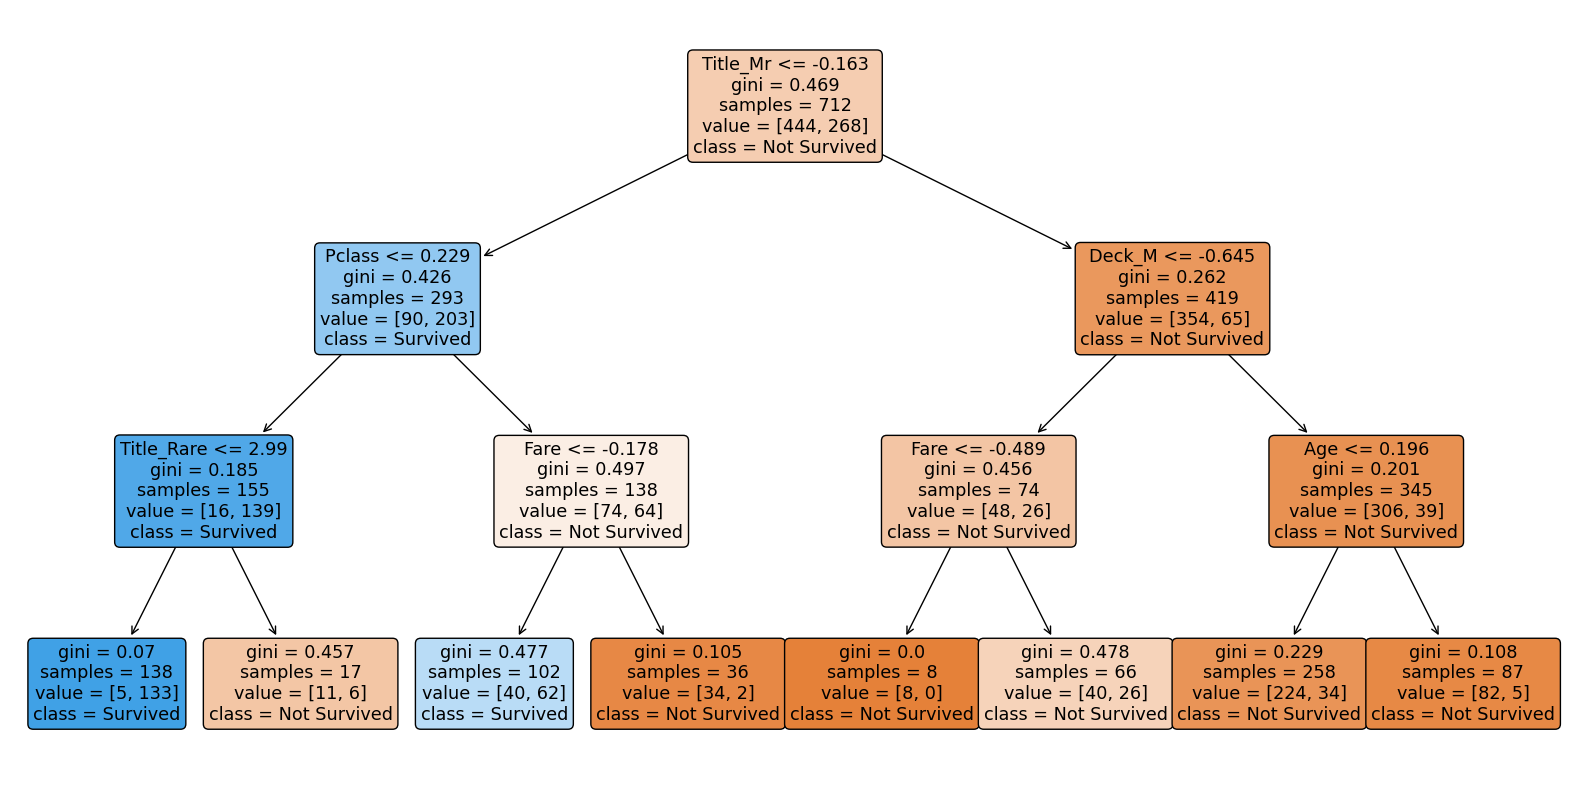

In [27]:
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier_fine_tuned, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], rounded=True)
plt.show()

# 3. Five Fold CV on Decision Tree and Average Classification Accuracy


In [28]:
scores = cross_val_score(dt_classifier_fine_tuned, X_train, y_train, cv=5, scoring='accuracy')
average_accuracy = scores.mean()

print(f'Average Classificaton Accuracy: {average_accuracy:.4f}')

Average Classificaton Accuracy: 0.8202


# 4. Five Fold CV on Random Forest and Average Classification Accuracy

In [29]:
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, params, cv=5, scoring='accuracy')

# Hyperparameter tuning
grid_search.fit(X_train, y_train)

fine_tuned_rf_classifier = grid_search.best_estimator_

# Applying 5-fold cross-validation and calculating the average accuracy
scores = cross_val_score(fine_tuned_rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
average_accuracy = scores.mean()

print(f'Average Classificaton Accuracy: {average_accuracy:.4f}')

Average Classificaton Accuracy: 0.8441
